In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *
import numpy as np
import pickle
import seaborn as sns

In [2]:
# Define input data from Excel file
def load_data(file_path):
    df1 = pd.read_excel(file_path, sheet_name="H2FlexCo", usecols="B:D", nrows=25)
    df2 = pd.read_excel(file_path, sheet_name="H2FlexCo", usecols="G:N", nrows=6)
    
    # Extract data
    hours = list(range(1, 25)) 
    electrolysers = list(range(1, 6))
    price_dam = {hours[i]: df1.iloc[i, 0] for i in range(len(hours))} 
    pv = {hours[i]: df1.iloc[i, 1] for i in range(len(hours))} 
    wind = {hours[i]: df1.iloc[i, 2] for i in range(len(hours))} 
    wind_cap = {electrolysers[j]: df2.iloc[j, 0] for j in range(len(electrolysers))}  
    pv_cap = {electrolysers[j]: df2.iloc[j, 1] for j in range(len(electrolysers))} 
    ees_cap = {electrolysers[j]: df2.iloc[j, 2] for j in range(len(electrolysers))} 
    el_max = {electrolysers[j]: df2.iloc[j, 3] for j in range(len(electrolysers))} 
    el_min = {electrolysers[j]: df2.iloc[j, 4] for j in range(len(electrolysers))}  
    comp = {electrolysers[j]: df2.iloc[j, 5] for j in range(len(electrolysers))} 
    eff = {electrolysers[j]: df2.iloc[j, 6] for j in range(len(electrolysers))}  
    flex = {electrolysers[j]: df2.iloc[j, 7] for j in range(len(electrolysers))} 
    
    return hours, electrolysers, price_dam, pv, wind, wind_cap, pv_cap, ees_cap, el_max, el_min, comp, eff, flex

In [3]:
# Load data
file_path = "SimData.xlsx"
hours, electrolysers, price_dam, pv, wind, wind_cap, pv_cap, ees_cap, el_max, el_min, comp, eff, flex = load_data(file_path)

In [4]:
# Define Pyomo model
model = ConcreteModel()

# Sets
model.e = RangeSet(1, 5) 
model.t = RangeSet(1, 24) 

# Parameters
model.lambda_DAM = Param(model.t, initialize=price_dam) 
model.lambda_BD = Param(initialize=5.85)  
model.lambda_UBD = Param(initialize=2) 
model.lambda_GO_Sell = Param(initialize=4)  
model.lambda_GO_Buy = Param(initialize=5)  
model.lambda_PPPA = Param(initialize=50) 
model.lambda_VPPA = Param(initialize=50) 
model.lambda_GO_PPA = Param(initialize=3) 
model.lambda_GA_TR = Param(initialize=8)  
model.eta_EL = Param(model.e, initialize=eff) 
model.Wind_Max = Param(model.e, initialize=wind_cap) 
model.PV_Max = Param(model.e, initialize=pv_cap) 
model.F_Wind = Param(model.t, initialize=wind) 
model.F_PV = Param(model.t, initialize=pv)  
model.eta_EES_Ch = Param(model.e, initialize=0.98) 
model.eta_EES_Dis = Param(model.e, initialize=0.98) 
model.EES_Ch_Max = Param(model.e, initialize=300)  
model.EES_Dis_Max = Param(model.e, initialize=300) 
model.gamma_GO = Param(initialize=1)  
model.E_EES_Min = Param(model.e, initialize=0)  
model.E_EES_Max = Param(model.e, initialize=ees_cap)  
model.P_EL_Max = Param(model.e, initialize=el_max)  
model.P_EL_Min = Param(model.e, initialize=el_min)  
model.M = Param(initialize=10000)  # Bid positive numbe
factor = {1: 2, 2: 0.6, 3: 0.6, 4: 0.6, 5: 0.6}
model.P_PPPA_H2FlexCo = Param(model.t, initialize=lambda model, t: sum(el_max[e] * factor[e] for e in model.e) * (0.8 * wind[t] + 0.2 * pv[t])) 
model.P_VPPA_H2FlexCo = Param(model.t, initialize=lambda model, t: 0.3 * sum(el_max[e] for e in model.e) * (0.7 * wind[t] + 0.3 * pv[t]))
model.DSP = Param(model.e, model.t, initialize=lambda model, e, t: eff[e] * el_max[e] * (1 - flex[e]))

# Variables
model.h_EL = Var(model.e, model.t, within=NonNegativeReals) 
model.p_EES = Var(model.e, model.t) 
model.h_BD = Var(model.e, model.t, within=NonNegativeReals)  
model.h_UBD = Var(model.e, model.t, within=NonNegativeReals) 
model.h_BD_H2FlexCo = Var(model.t, within=NonNegativeReals) 
model.h_UBD_H2FlexCo = Var(model.t, within=NonNegativeReals) 
model.p_DAM_Buy = Var(model.e, model.t, within=NonNegativeReals)  
model.p_DAM_Sell = Var(model.e, model.t, within=NonNegativeReals)  
model.p_DAM_H2FlexCo_Buy = Var(model.t, within=NonNegativeReals)  
model.p_DAM_H2FlexCo_Sell = Var(model.t, within=NonNegativeReals) 
model.p_PPPA = Var(model.e, model.t, within=NonNegativeReals)  
model.p_VPPA = Var(model.e, model.t, within=NonNegativeReals)  
model.c_CfD = Var(model.t) 
model.p_EL = Var(model.e, model.t, bounds=lambda model, e, t: (model.P_EL_Min[e], model.P_EL_Max[e]))  
model.e_EES = Var(model.e, model.t, bounds=lambda model, e, t: (model.E_EES_Min[e], model.E_EES_Max[e]))  
model.p_Ch = Var(model.e, model.t, within=NonNegativeReals) 
model.p_Dis = Var(model.e, model.t, within=NonNegativeReals) 
model.p_Local = Var(model.e, model.t, within=NonNegativeReals) 
model.n_Sell_H2FlexCo = Var(model.t, within=NonNegativeReals) 
model.n_Buy_H2FlexCo = Var(model.t, within=NonNegativeReals)  
model.n_GO_Sell = Var(model.e, model.t, within=NonNegativeReals) 
model.n_GO_Buy = Var(model.e, model.t, within=NonNegativeReals) 
model.n_VPPA = Var(model.e, model.t, within=NonNegativeReals)  
model.n_VPPA_H2FlexCo = Var(model.t, within=NonNegativeReals) 
model.n_PPPA = Var(model.e, model.t, within=NonNegativeReals) 
model.n_GO_Local = Var(model.e, model.t, within=NonNegativeReals) 
model.n_GO_BD = Var(model.e, model.t, within=NonNegativeReals)  
model.n_GO_DSP = Var(model.e, model.t, within=NonNegativeReals) 

# Binary Variables
model.i_EES_Ch = Var(model.e, model.t, within=Binary)  
model.i_EES_Dis = Var(model.e, model.t, within=Binary)
model.i_GO_Buy = Var(model.e, model.t, within=Binary)  
model.i_GO_Sell = Var(model.e, model.t, within=Binary)
model.i_DAM_Buy = Var(model.e, model.t, within=Binary) 
model.i_DAM_Sell = Var(model.e, model.t, within=Binary) 

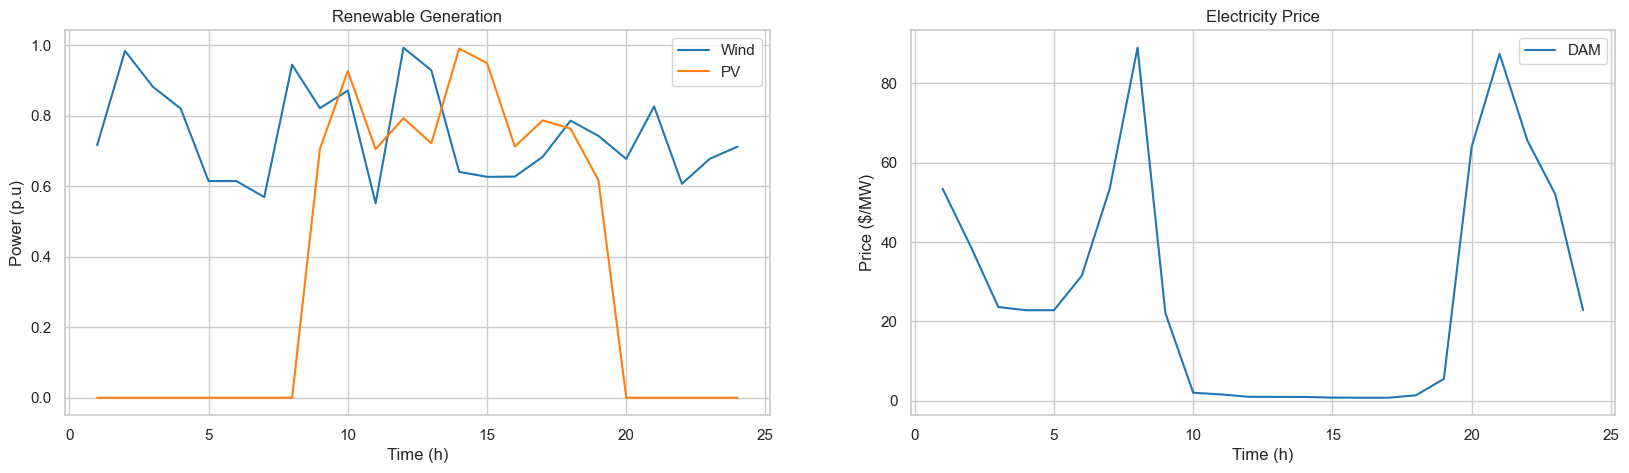

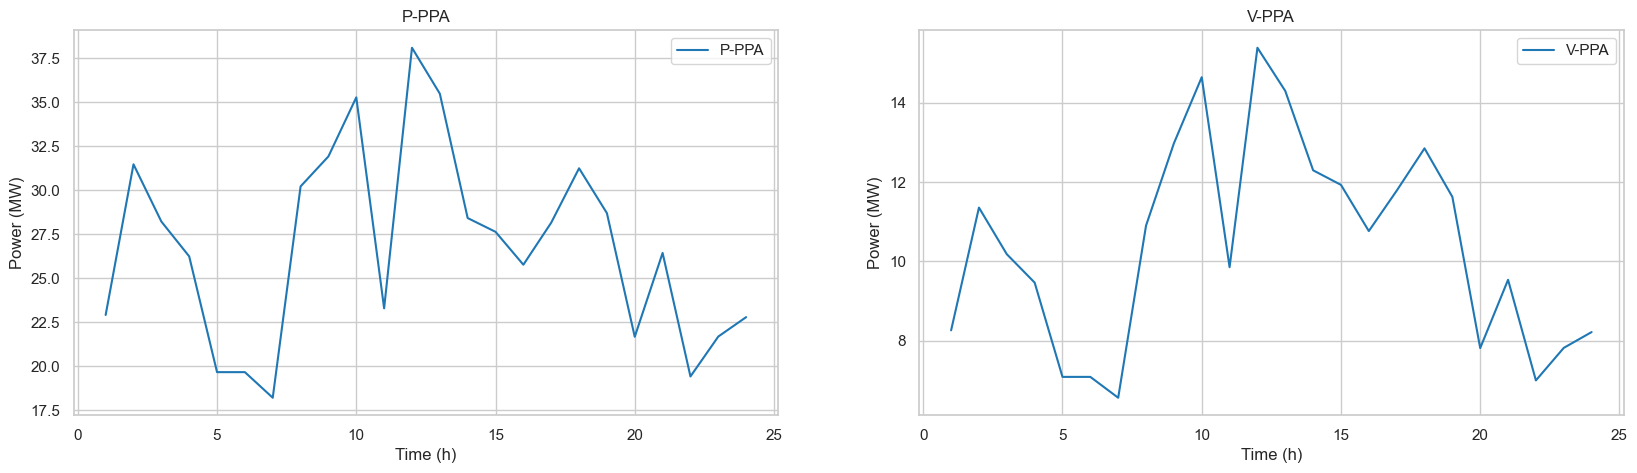

In [16]:
# Plot input data
sns.set_context("notebook")
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.lineplot(x=hours, y=[wind[t] for t in hours], label="Wind", ax=axes[0])
sns.lineplot(x=hours, y=[pv[t] for t in hours], label="PV", ax=axes[0])
axes[0].set_xlabel("Time (h)")
axes[0].set_ylabel("Power (p.u)")
axes[0].set_title("Renewable Generation")
axes[0].legend()
sns.lineplot(x=hours, y=[price_dam[t] for t in hours], label="DAM", ax=axes[1])
axes[1].set_xlabel("Time (h)")
axes[1].set_ylabel("Price ($/MW)")
axes[1].set_title("Electricity Price")
axes[1].legend()
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.lineplot(x=hours, y=[model.P_PPPA_H2FlexCo[t] for t in hours], label="P-PPA", ax=axes[0])
axes[0].set_xlabel("Time (h)")
axes[0].set_ylabel("Power (MW)")
axes[0].set_title("P-PPA")
axes[0].legend()
sns.lineplot(x=hours, y=[model.P_VPPA_H2FlexCo[t] for t in hours], label="V-PPA", ax=axes[1])
axes[1].set_xlabel("Time (h)")
axes[1].set_ylabel("Power (MW)")
axes[1].set_title("V-PPA")
axes[1].legend()
plt.show()

In [6]:
# Constraints
def constraint_d2(model, t):
    return model.c_CfD[t] == (model.lambda_VPPA - model.lambda_DAM[t]) * model.P_VPPA_H2FlexCo[t]
def constraint_d3(model, e, t):
    return model.h_EL[e, t] == model.eta_EL[e] * model.p_EL[e, t]
def constraint_d4(model, e, t):
    return model.p_PPPA[e, t] + model.p_DAM_Buy[e, t] + model.p_Local[e, t] == model.p_EL[e, t] + model.p_EES[e, t] + model.p_DAM_Sell[e, t]
def constraint_d5(model, e, t):
    return model.p_Local[e, t] == model.F_Wind[t] * model.Wind_Max[e] * 0 + model.F_PV[t] * model.PV_Max[e] * 0
def constraint_d7(model, t):
    return sum(model.p_PPPA[e, t]  for e in model.e) == model.P_PPPA_H2FlexCo[t]
def constraint_d8(model, t):
    return sum(model.p_VPPA[e, t] for e in model.e) == model.P_VPPA_H2FlexCo[t]
def constraint_d9(model, t):
    return sum(model.p_DAM_Buy[e, t] for e in model.e) == model.p_DAM_H2FlexCo_Buy[t]
def constraint_d10(model, t):
    return sum(model.p_DAM_Sell[e, t] for e in model.e) == model.p_DAM_H2FlexCo_Sell[t]
def constraint_d11(model, e, t):
    return model.p_DAM_Buy[e, t] <= model.M * model.i_DAM_Buy[e, t]
def constraint_d12(model, e, t):
    return model.p_DAM_Sell[e, t] <= model.M * model.i_DAM_Sell[e, t]
def constraint_d13(model, e, t):
    return model.i_DAM_Sell[e, t] + model.i_DAM_Buy[e, t] <= 1
def constraint_d14(model, e, t):
    if t == 1:
        return model.e_EES[e, t] == 0.5 * model.E_EES_Max[e] + model.eta_EES_Ch[e] * model.p_Ch[e, t] - model.p_Dis[e, t] / model.eta_EES_Dis[e]
    if t == len(model.t):
        return model.e_EES[e, t] == 0.5 * model.E_EES_Max[e] 
    return model.e_EES[e, t] == model.e_EES[e, t-1] + model.eta_EES_Ch[e] * model.p_Ch[e, t] - model.p_Dis[e, t] / model.eta_EES_Dis[e]
def constraint_d15(model, e, t):
    return model.p_Ch[e, t] <= model.EES_Ch_Max[e] * model.i_EES_Ch[e, t]
def constraint_d16(model, e, t):
    return model.p_Dis[e, t] <= model.EES_Dis_Max[e] * model.i_EES_Dis[e, t]
def constraint_d17(model, e, t):
    return model.i_EES_Ch[e, t] + model.i_EES_Dis[e, t] <= 1 * 0
def constraint_d18(model, e, t):
    return model.p_EES[e, t] == model.p_Ch[e, t] - model.p_Dis[e, t]

def constraint_d20(model, e, t):
    return model.h_EL[e, t] == model.h_BD[e, t] + model.h_UBD[e, t] + model.DSP[e, t]
def constraint_d21(model, t):
    return sum(model.h_BD[e, t] for e in model.e) == model.h_BD_H2FlexCo[t]
def constraint_d22(model, t):
    return sum(model.h_UBD[e, t] for e in model.e) == model.h_UBD_H2FlexCo[t]
def constraint_d23(model, e):
    return sum(model.n_VPPA[e, t] + model.n_PPPA[e, t] + model.n_GO_Local[e, t] + model.n_GO_Buy[e, t] for t in model.t) == \
    sum(model.n_GO_Sell[e, t] + model.n_GO_BD[e, t] + model.n_GO_DSP[e, t] for t in model.t)
def constraint_d24(model, e, t):
    return model.n_VPPA[e, t] == model.gamma_GO * model.p_VPPA[e, t]
def constraint_d25(model, e, t):
    return model.n_PPPA[e, t] == model.gamma_GO * model.p_PPPA[e, t]
def constraint_d26(model, e, t):
    return model.n_GO_Local[e, t] == model.gamma_GO * model.p_Local[e, t] 
def constraint_d27(model, e, t):
    return model.n_GO_BD[e, t] == model.gamma_GO * (model.h_BD[e, t] / model.eta_EL[e])
def constraint_d28(model):
    return (1 / model.gamma_GO) * sum(model.n_VPPA[e, t] + model.n_PPPA[e, t] + model.n_GO_Local[e, t] + model.n_GO_Buy[e, t] 
    - model.n_GO_Sell[e, t] for e in model.e for t in model.t) >= (1 - 0.1) * sum((model.h_BD[e, t] + model.DSP[e, t] + model.h_UBD[e, t]) / model.eta_EL[e] 
                                                                      for e in model.e for t in model.t)
def constraint_d29(model, e, t):
    return model.n_GO_Sell[e, t] <= model.i_GO_Sell[e, t] * model.M
def constraint_d30(model, e, t):
    return model.n_GO_Buy[e, t] <= model.i_GO_Buy[e, t] * model.M
def constraint_d31(model, e, t):
    return model.i_GO_Sell[e, t] + model.i_GO_Buy[e, t] <= 1
def constraint_d32(model, t):
    return sum(model.n_VPPA[e, t] for e in model.e) == model.n_VPPA_H2FlexCo[t]
def constraint_d33(model, t):
    return sum(model.n_GO_Sell[e, t] for e in model.e) == model.n_Sell_H2FlexCo[t]
def constraint_d34(model, t):
    return sum(model.n_GO_Buy[e, t] for e in model.e) == model.n_Buy_H2FlexCo[t]
def constraint_d35(model, e, t):
    return model.n_GO_DSP[e, t] == model.gamma_GO * (model.DSP[e, t] / model.eta_EL[e])
def constraint_d36(model):
    return sum(model.n_GO_Buy[e, t] for e in model.e for t in model.t) <= 220
def constraint_d37(model):
    return sum(model.n_GO_Sell[e, t] for e in model.e for t in model.t) <= model.M
   
model.constraint_d2 = Constraint(model.t, rule=constraint_d2)
model.constraint_d3 = Constraint(model.e, model.t, rule=constraint_d3)
model.constraint_d4 = Constraint(model.e, model.t, rule=constraint_d4)
model.constraint_d5 = Constraint(model.e, model.t, rule=constraint_d5)
model.constraint_d7 = Constraint(model.t, rule=constraint_d7)
model.constraint_d8 = Constraint(model.t, rule=constraint_d8)
model.constraint_d9 = Constraint(model.t, rule=constraint_d9)
model.constraint_d10 = Constraint(model.t, rule=constraint_d10)
model.constraint_d11 = Constraint(model.e, model.t, rule=constraint_d11)
model.constraint_d12 = Constraint(model.e, model.t, rule=constraint_d12)
model.constraint_d13 = Constraint(model.e, model.t, rule=constraint_d13)
model.constraint_d14 = Constraint(model.e, model.t, rule=constraint_d14)
model.constraint_d15 = Constraint(model.e, model.t, rule=constraint_d15)
model.constraint_d16 = Constraint(model.e, model.t, rule=constraint_d16)
model.constraint_d17 = Constraint(model.e, model.t, rule=constraint_d17)
model.constraint_d18 = Constraint(model.e, model.t, rule=constraint_d18)
model.constraint_d20 = Constraint(model.e, model.t, rule=constraint_d20)
model.constraint_d21 = Constraint(model.t, rule=constraint_d21)
model.constraint_d22 = Constraint(model.t, rule=constraint_d22)
model.constraint_d23 = Constraint(model.e, rule=constraint_d23)
model.constraint_d24 = Constraint(model.e, model.t, rule=constraint_d24)
model.constraint_d25 = Constraint(model.e, model.t, rule=constraint_d25)
model.constraint_d26 = Constraint(model.e, model.t, rule=constraint_d26)
model.constraint_d27 = Constraint(model.e, model.t, rule=constraint_d27)
model.constraint_d28 = Constraint(rule=constraint_d28)
model.constraint_d29 = Constraint(model.e, model.t, rule=constraint_d29)
model.constraint_d30 = Constraint(model.e, model.t, rule=constraint_d30)
model.constraint_d31 = Constraint(model.e, model.t, rule=constraint_d31)
model.constraint_d32 = Constraint(model.t, rule=constraint_d32)
model.constraint_d33 = Constraint(model.t, rule=constraint_d33)
model.constraint_d34 = Constraint(model.t, rule=constraint_d34)
model.constraint_d35 = Constraint(model.e, model.t, rule=constraint_d35)
model.constraint_d36 = Constraint(rule=constraint_d36)
model.constraint_d37 = Constraint(rule=constraint_d37)

In [7]:
# Objective Function
model.z_H2FlexCo = Objective(
    expr=sum(
        model.lambda_BD * model.h_BD_H2FlexCo[t]
        + model.lambda_UBD * model.h_UBD_H2FlexCo[t]
        + model.lambda_GO_Sell * model.n_Sell_H2FlexCo[t]
        + 0.9 * model.lambda_DAM[t] * model.p_DAM_H2FlexCo_Sell[t]
        - model.lambda_GO_Buy * model.n_Buy_H2FlexCo[t]
        - model.lambda_GO_PPA * model.n_VPPA_H2FlexCo[t]
        - model.lambda_DAM[t] * model.p_DAM_H2FlexCo_Buy[t]
        - 1.05 * model.lambda_PPPA * model.P_PPPA_H2FlexCo[t]
        - model.lambda_GA_TR * model.P_PPPA_H2FlexCo[t]
        - model.c_CfD[t]
        for t in model.t
    ),
    sense=maximize
)

In [8]:
# Solve the model using GLPK
solver = SolverFactory('glpk')
result = solver.solve(model)
print(result.solver.termination_condition)
print("Objective value:", round(value(model.z_H2FlexCo),3), "\N{euro sign}")
print("-------------------------------------------------------------------------------------------------------------") 
print("GOs (Buy):", round(sum(model.n_GO_Buy[e, t].value for e in model.e for t in model.t),3), "Unit")
print("-------------------------------------------------------------------------------------------------------------") 
for e in model.e:
    print("GOs (Buy):", round(sum(model.n_GO_Buy[e, t].value for t in model.t),3), "Unit")
print("-------------------------------------------------------------------------------------------------------------")   
print("GOs (Sell):", round(sum(model.n_GO_Sell[e, t].value for e in model.e for t in model.t),3), "Unit")
print("-------------------------------------------------------------------------------------------------------------")  
for e in model.e:
    print("GOs (Sell):", round(sum(model.n_GO_Sell[e, t].value for t in model.t),3), "Unit")
print("-------------------------------------------------------------------------------------------------------------")  
print("DAM (Buy):", round(sum(model.p_DAM_Buy[e, t].value for e in model.e for t in model.t),3), "MW",
     "- DAM (Sell):", round(sum(model.p_DAM_Sell[e, t].value for e in model.e for t in model.t),3), "MW",
     "- Hydrogen (BD):", round(sum(model.h_BD[e, t].value for e in model.e for t in model.t),3), "kg",
     "- Hydrogen (UBD):", round(sum(model.h_UBD[e, t].value for e in model.e for t in model.t),3), "kg")
print("-------------------------------------------------------------------------------------------------------------")  
for e in model.e:
    print("DAM (Buy):", round(sum(model.p_DAM_Buy[e, t].value for t in model.t),3), "MW",
     "- DAM (Sell):", round(sum(model.p_DAM_Sell[e, t].value for t in model.t),3), "MW",
     "- Hydrogen (BD):", round(sum(model.h_BD[e, t].value for t in model.t),3), "kg",
     "- Hydrogen (UBD):", round(sum(model.h_UBD[e, t].value for t in model.t),3), "kg")
print("-------------------------------------------------------------------------------------------------------------")  
print("Green Hydrogen Rate:", round(((1 / model.gamma_GO) * sum(model.n_VPPA[e, t].value + model.n_PPPA[e, t].value + model.n_GO_Local[e, t].value + model.n_GO_Buy[e, t].value 
    - model.n_GO_Sell[e, t].value for e in model.e for t in model.t)) / (sum((model.h_EL[e, t].value) / model.eta_EL[e] 
    for e in model.e for t in model.t)) * 100, 3), "%", f"({round(sum(model.h_EL[e, t].value for e in model.e for t in model.t), 3)} kg)")
print("-------------------------------------------------------------------------------------------------------------") 
for e in model.e:
    print("Green Hydrogen Rate:", round(((1 / model.gamma_GO) * sum(model.n_VPPA[e, t].value + model.n_PPPA[e, t].value + model.n_GO_Local[e, t].value + model.n_GO_Buy[e, t].value 
    - model.n_GO_Sell[e, t].value  for t in model.t)) / (sum((model.h_EL[e, t].value) / model.eta_EL[e] for t in model.t)) * 100, 3), "%", 
         f"({round(sum(model.h_EL[e, t].value for t in model.t), 3)} kg)")
print("-------------------------------------------------------------------------------------------------------------") 

optimal
Objective value: -52227.466 €
-------------------------------------------------------------------------------------------------------------
GOs (Buy): 220.0 Unit
-------------------------------------------------------------------------------------------------------------
GOs (Buy): 0.0 Unit
GOs (Buy): 0.0 Unit
GOs (Buy): 184.372 Unit
GOs (Buy): 0.0 Unit
GOs (Buy): 35.628 Unit
-------------------------------------------------------------------------------------------------------------
GOs (Sell): 0.0 Unit
-------------------------------------------------------------------------------------------------------------
GOs (Sell): 0.0 Unit
GOs (Sell): 0.0 Unit
GOs (Sell): 0.0 Unit
GOs (Sell): 0.0 Unit
GOs (Sell): 0.0 Unit
-------------------------------------------------------------------------------------------------------------
DAM (Buy): 593.293 MW - DAM (Sell): 0.0 MW - Hydrogen (BD): 881.76 kg - Hydrogen (UBD): 2471.307 kg
---------------------------------------------------------

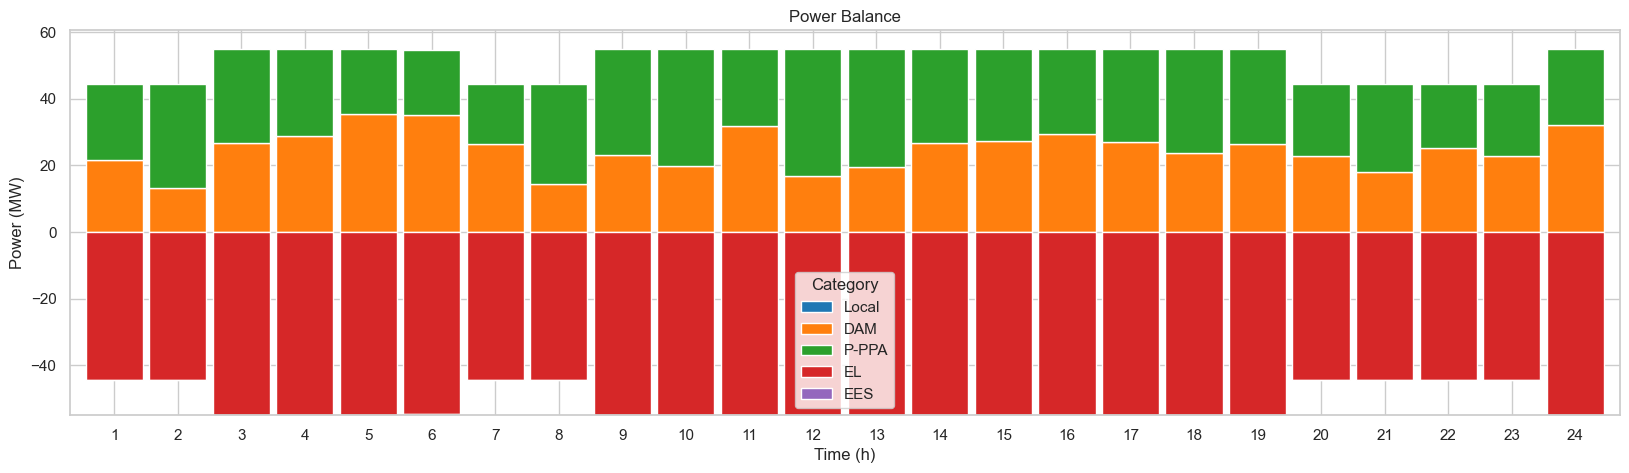

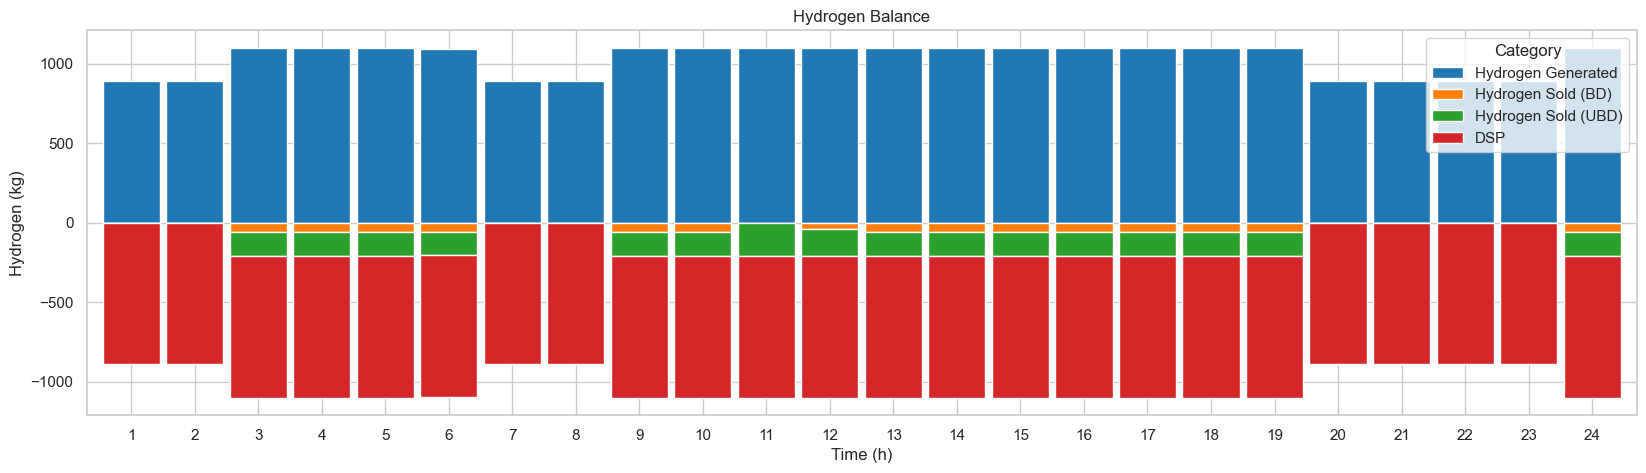

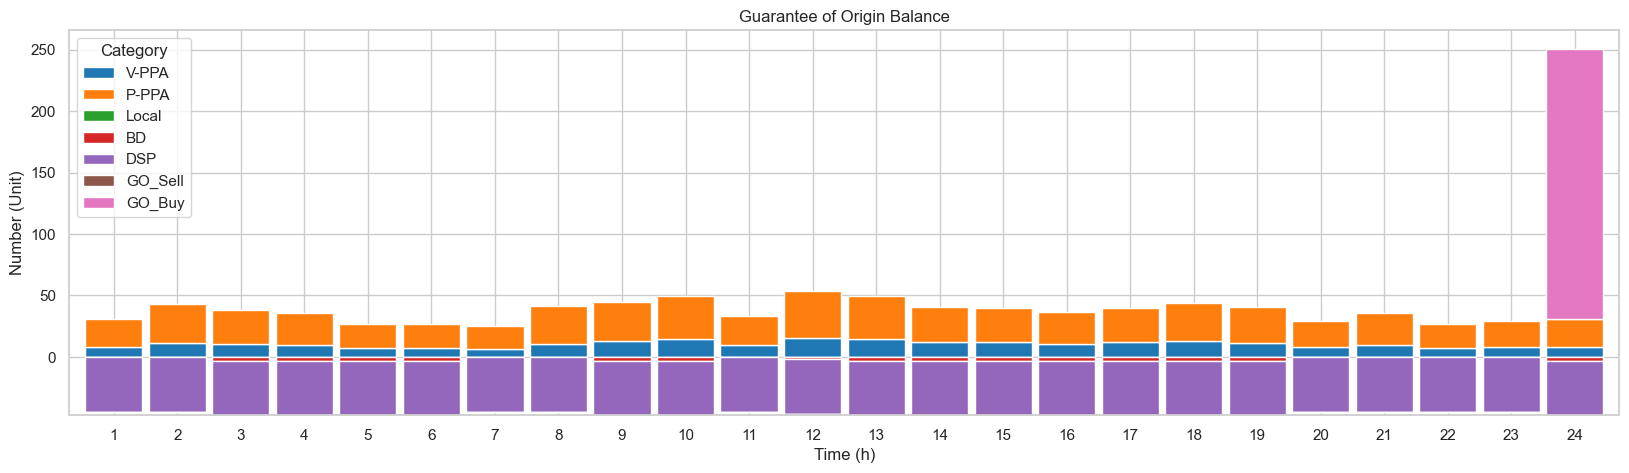

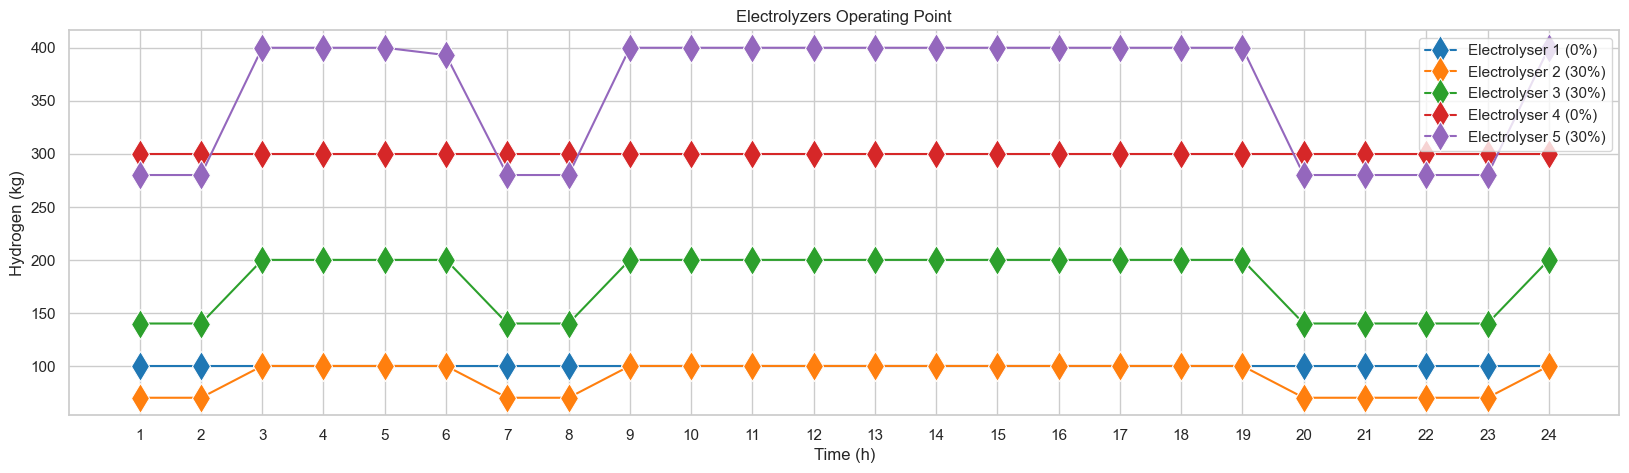

In [18]:
# Plot output data
sns.set_context("notebook")
sns.set_style("whitegrid")
colors = sns.color_palette("pastel")
fig, ax = plt.subplots(figsize=(20, 5))
df = pd.DataFrame({
    "Time": np.array(hours),
    "Local": np.array([sum(model.p_Local[e, t].value for e in electrolysers) for t in hours]),
    "DAM": np.array([sum(model.p_DAM_Buy[e, t].value - model.p_DAM_Sell[e, t].value for e in electrolysers) for t in hours]),
    "P-PPA": np.array([sum(model.p_PPPA[e, t].value for e in electrolysers) for t in hours]),
    "EL": -np.array([sum(model.p_EL[e, t].value for e in electrolysers) for t in hours]),
    "EES": -np.array([sum(model.p_EES[e, t].value for e in electrolysers) for t in hours])
})
df.set_index("Time").plot(kind="bar", stacked=True, ax=ax, width=0.9)
ax.tick_params(axis='x', rotation=0)
plt.xlabel("Time (h)")
plt.ylabel("Power (MW)")
plt.title("Power Balance")
plt.legend(title="Category")
fig, ax = plt.subplots(figsize=(20, 5))
df = pd.DataFrame({
    "Time": np.array(hours),
    "Hydrogen Generated": np.array([sum(model.h_EL[e, t].value for e in electrolysers) for t in hours]),
    "Hydrogen Sold (BD)": -np.array([sum(model.h_BD[e, t].value for e in electrolysers) for t in hours]),
    "Hydrogen Sold (UBD)": -np.array([sum(model.h_UBD[e, t].value for e in electrolysers) for t in hours]),
    "DSP": -np.array([sum(model.DSP[e, t] for e in electrolysers) for t in hours])
})
df.set_index("Time").plot(kind="bar", stacked=True, ax=ax, width=0.9)
ax.tick_params(axis='x', rotation=0)
plt.xlabel("Time (h)")
plt.ylabel("Hydrogen (kg)")
plt.title("Hydrogen Balance")
plt.legend(title="Category")
fig, ax = plt.subplots(figsize=(20, 5))
df = pd.DataFrame({
    "Time": np.array(hours),
    "V-PPA": np.array([sum(model.n_VPPA[e, t].value for e in electrolysers) for t in hours]),
    "P-PPA": np.array([sum(model.n_PPPA[e, t].value for e in electrolysers) for t in hours]),
    "Local": np.array([sum(model.n_GO_Local[e, t].value for e in electrolysers) for t in hours]),
    "BD": -np.array([sum(model.n_GO_BD[e, t].value for e in electrolysers) for t in hours]),
    "DSP": -np.array([sum(model.n_GO_DSP[e, t].value for e in electrolysers) for t in hours]),
    "GO_Sell": -np.array([sum(model.n_GO_Sell[e, t].value for e in electrolysers) for t in hours]),
    "GO_Buy": np.array([sum(model.n_GO_Buy[e, t].value for e in electrolysers) for t in hours])
})
df.set_index("Time").plot(kind="bar", stacked=True, ax=ax, width=0.9)
ax.tick_params(axis='x', rotation=0)
plt.xlabel("Time (h)")
plt.ylabel("Number (Unit)")
plt.title("Guarantee of Origin Balance")
plt.legend(title="Category")
fig, ax = plt.subplots(figsize=(20, 5))
records = []
for e in range(len(electrolysers)):
    label = f"Electrolyser {e+1} ({round((1 - (model.P_EL_Min[e+1] / model.P_EL_Max[e+1])) * 100)}%)"
    for t in hours:
        records.append({
            "Hour": t,
            "Hydrogen": model.h_EL[e+1, t].value,
            "Electrolyser": label
        })
df = pd.DataFrame(records)
sns.lineplot(data=df, x="Hour", y="Hydrogen", hue="Electrolyser", marker='d', ax=ax, markersize=15)
ax.tick_params(axis='x', rotation=0)
plt.xlabel("Time (h)")
plt.ylabel("Hydrogen (kg)")
plt.title("Electrolyzers Operating Point")
plt.xticks(range(1, 25))
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Export results
P_H2FlexCo = {(1, t):sum(model.p_DAM_Buy[e, t].value - model.p_DAM_Sell[e, t].value for e in model.e) for t in model.t}
lambda_H2FlexCo = {(1, t): model.lambda_DAM[t] for t in model.t}
N_H2FlexCo = {(1, t): model.n_Sell_H2FlexCo[t].value - model.n_Buy_H2FlexCo[t].value for t in model.t}
P_H2FlexCo_buy = {(1, t): P_H2FlexCo[1, t] if P_H2FlexCo[1,t]>0 else 0 for t in model.t}
P_H2FlexCo_sell = {(31, t): -P_H2FlexCo[1, t] if P_H2FlexCo[1,t]<0 else 0 for t in model.t}
lambda_H2FlexCo_buy = {(1, t): lambda_H2FlexCo[1, t] for t in model.t}
lambda_H2FlexCo_sell = {(31, t): lambda_H2FlexCo[1, t] for t in model.t}
N_H2FlexCo_sell = {(31, 1): sum(N_H2FlexCo[1, t] if N_H2FlexCo[1, t]>0 else 0 for t in model.t)}
N_H2FlexCo_buy = {(1, 1): -sum(N_H2FlexCo[1, t] if N_H2FlexCo[1, t]<0 else 0 for t in model.t)}
lambda_GO_buy = {(1, 1): model.lambda_GO_Buy.value}
lambda_GO_sell = {(31, 1): model.lambda_GO_Sell.value}
P_PPA = {(1, 1):sum(model.p_PPPA[e, t].value + model.p_VPPA[e, t].value for e in model.e for t in model.t)}
lambda_PPA = {(1, 1): model.lambda_PPPA.value}
data=[P_H2FlexCo_buy, P_H2FlexCo_sell, lambda_H2FlexCo_buy, lambda_H2FlexCo_sell, N_H2FlexCo_buy, N_H2FlexCo_sell, lambda_GO_buy, lambda_GO_sell, \
     P_PPA, lambda_PPA]
with open("H2FlexCo.pkl", "wb") as f:
    pickle.dump(data, f)

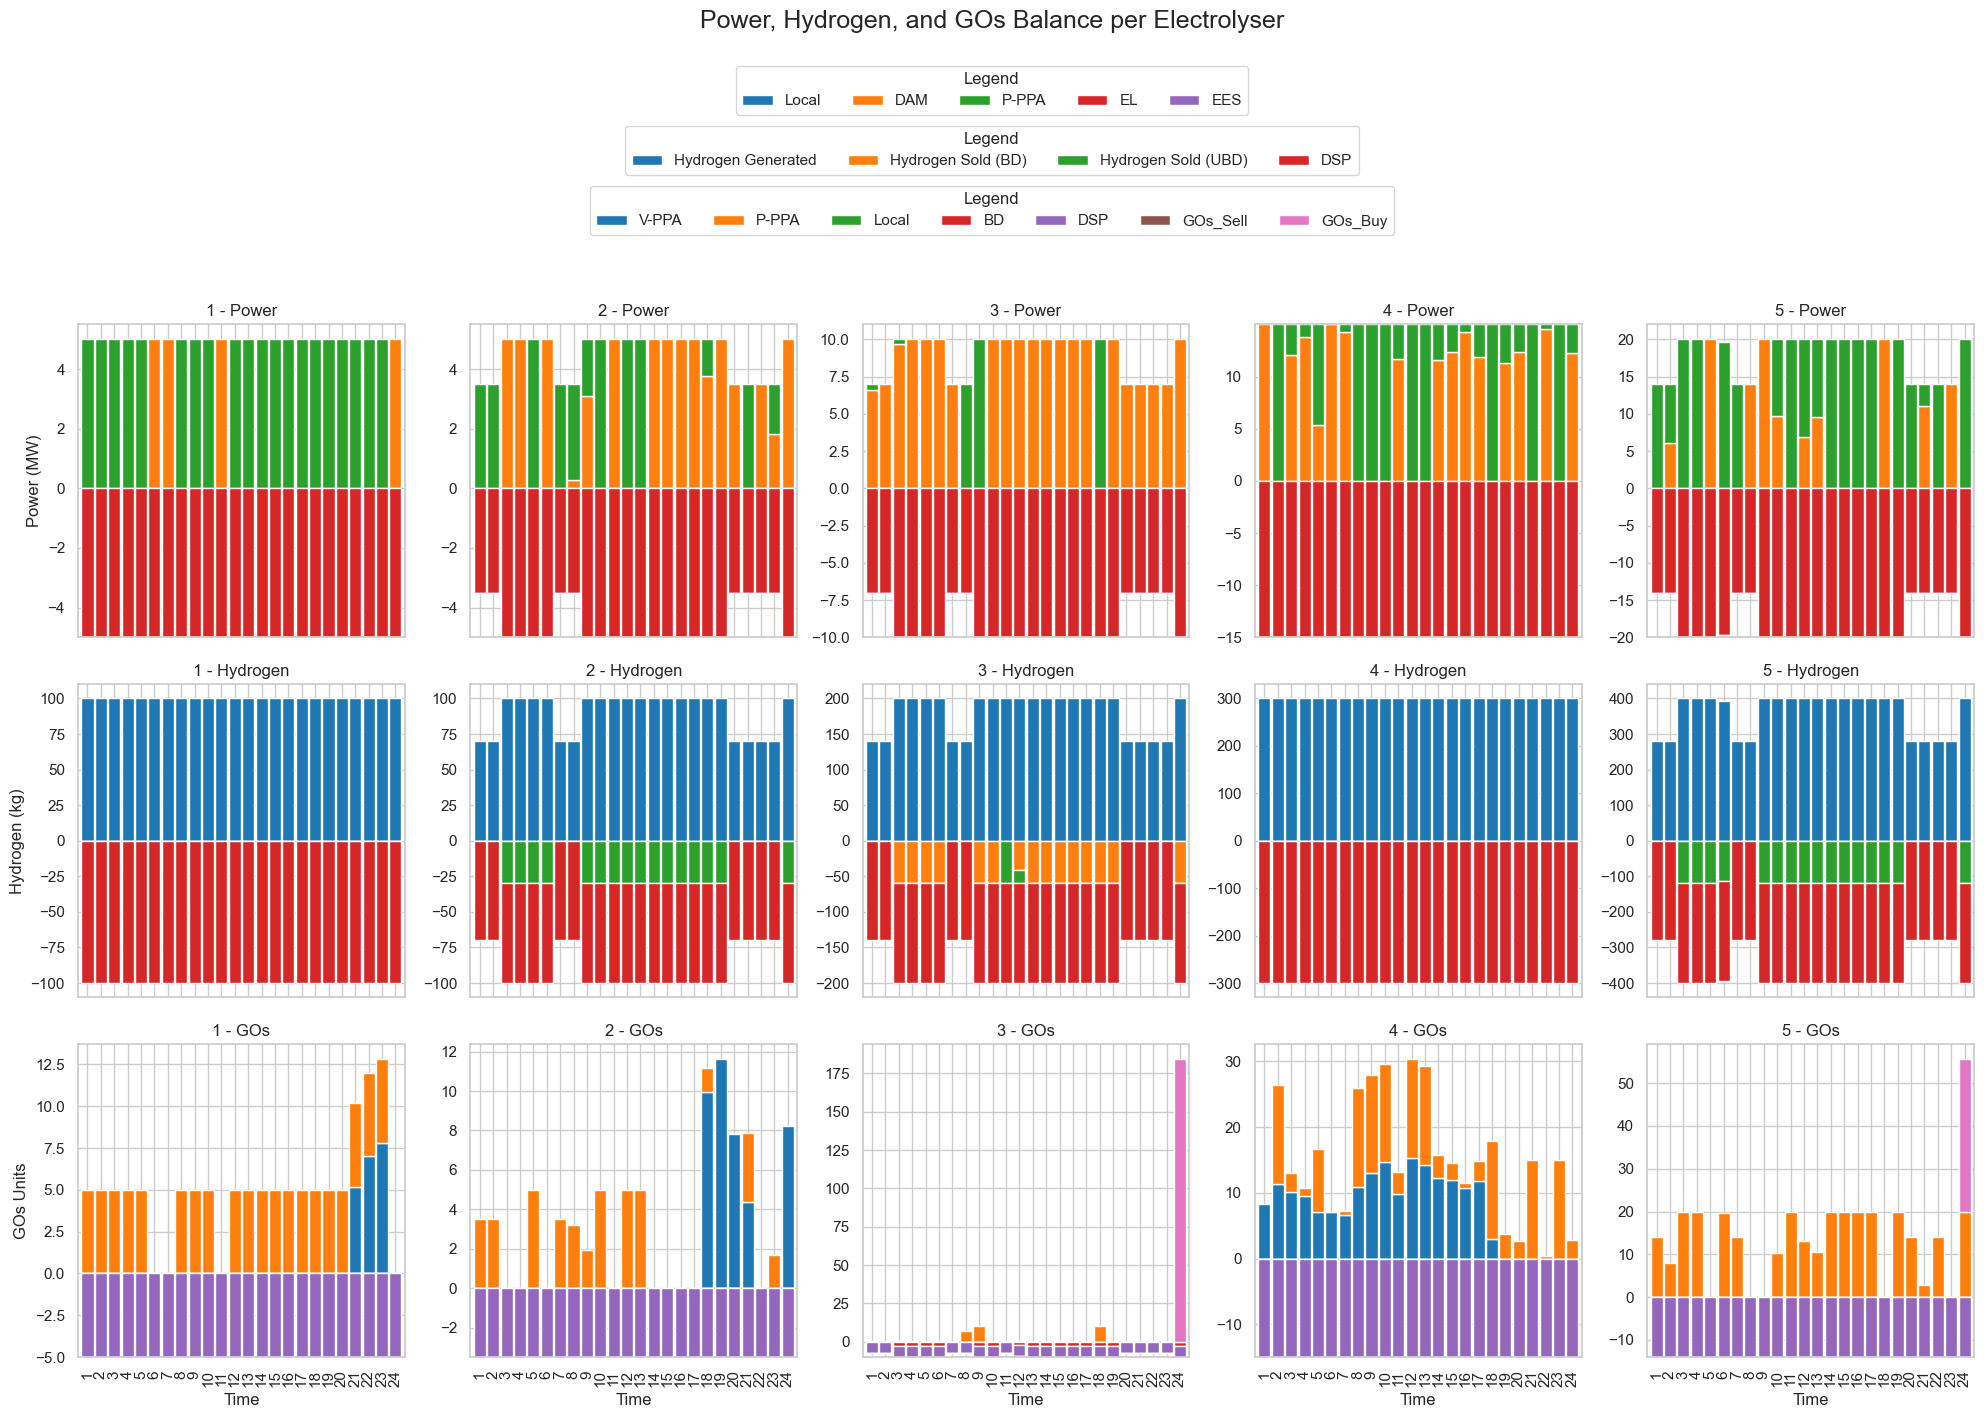

In [11]:
n = len(electrolysers)
categories = ['Power', 'Hydrogen', 'GOs']
fig, axes = plt.subplots(nrows=3, ncols=n, figsize=(4 * n, 12), sharex=True)
for col_idx, e in enumerate(electrolysers):
    df_power = pd.DataFrame({
        "Time": np.array(hours),
        "Local": np.array([value(model.p_Local[e, t]) for t in hours]),
        "DAM": np.array([value(model.p_DAM_Buy[e, t]) - value(model.p_DAM_Sell[e, t]) for t in hours]),
        "P-PPA": np.array([value(model.p_PPPA[e, t]) for t in hours]),
        "EL": -np.array([value(model.p_EL[e, t]) for t in hours]),
        "EES": -np.array([value(model.p_EES[e, t]) for t in hours])
    })
    ax = axes[0, col_idx]
    plot = df_power.set_index("Time").plot(kind="bar", stacked=True, ax=ax, width=0.9, legend=False)
    if col_idx == 0:
        ax.set_ylabel("Power (MW)")
    ax.set_title(f"{e} - Power")
    df_h2 = pd.DataFrame({
        "Time": np.array(hours),
        "Hydrogen Generated": np.array([value(model.h_EL[e, t]) for t in hours]),
        "Hydrogen Sold (BD)": -np.array([value(model.h_BD[e, t]) for t in hours]),
        "Hydrogen Sold (UBD)": -np.array([value(model.h_UBD[e, t]) for t in hours]),
        "DSP": -np.array([value(model.DSP[e, t]) for t in hours])
    })
    ax = axes[1, col_idx]
    plot = df_h2.set_index("Time").plot(kind="bar", stacked=True, ax=ax, width=0.9, legend=False)
    if col_idx == 0:
        ax.set_ylabel("Hydrogen (kg)")
    ax.set_title(f"{e} - Hydrogen")
    df_go = pd.DataFrame({
        "Time": np.array(hours),
        "V-PPA": np.array([value(model.n_VPPA[e, t]) for t in hours]),
        "P-PPA": np.array([value(model.n_PPPA[e, t]) for t in hours]),
        "Local": np.array([value(model.n_GO_Local[e, t]) for t in hours]),
        "BD": -np.array([value(model.n_GO_BD[e, t]) for t in hours]),
        "DSP": -np.array([value(model.n_GO_DSP[e, t]) for t in hours]),
        "GOs_Sell": -np.array([value(model.n_GO_Sell[e, t]) for t in hours]),
        "GOs_Buy": np.array([value(model.n_GO_Buy[e, t]) for t in hours])
    })
    ax = axes[2, col_idx]
    plot = df_go.set_index("Time").plot(kind="bar", stacked=True, ax=ax, width=0.9, legend=False)
    if col_idx == 0:
        ax.set_ylabel("GOs Units")
    ax.set_title(f"{e} - GOs")
power_handles, power_labels = axes[0, 0].get_legend_handles_labels()
h2_handles, h2_labels = axes[1, 0].get_legend_handles_labels()
go_handles, go_labels = axes[2, 0].get_legend_handles_labels()
fig.legend(power_handles, power_labels, title="Legend", loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.14))
fig.legend(h2_handles, h2_labels, title="Legend", loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.09))
fig.legend(go_handles, go_labels, title="Legend", loc="upper center", ncol=7, bbox_to_anchor=(0.5, 1.04))
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Power, Hydrogen, and GOs Balance per Electrolyser", fontsize=18, y=1.18)
plt.show()